Paul O'Leary

Comp 4449

Data Science Capstone

Midterm

Detecting Credit Card Fraud

---------------------------

In this project, various methods of handling imbalanced data will be examined.  Those methods will be put to the test by a variety of classification techniques, and the results will be discussed.

Most of my time was focused on the different methods of balancing the data to make it more amenable to be classified.  I also began to spend time working with Outlier Detection approaches, using Isolation Forests, for example.  Those initial attempts are at the end of the code, but not discussed in the Presentation nor the Report.

---------------------------

Information from the Kaggle Site, which is the source of the data:

# Detecting Credit Card Fraud
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase. The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. The goal of this project is to build a model able to recognize fraudulent credit card transactions. More info [here](https://www.kaggle.com/mlg-ulb/creditcardfraud).

In [2]:
# Import some base libraries.  More will be imported throughout the notebook.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import timeit

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
# Import the data.

trans_a = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectCCF/data/creditcard_a.csv")
trans_a.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
trans_b = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectCCF/data/creditcard_b.csv")
trans_b.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
96541,172786,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
96542,172787,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
96543,172788,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
96544,172788,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
96545,172792,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


The data is downloaded in two batches, each representing a day of credit card transactions.  To ensure confidentiality, the data has been run through Principal Component Analysis, and is presented here as numeric data, columns "V1" through "V28", with the exception of a "Time" stamp, an "Amount" field, and "Class":

+ Columns V1 - V28:  Anonymized and confidential numeric data.  Sadly, all context has been removed.
+ Time:  Elapsed time from the start of the day.
+ Amount:  The amount of the transaction in some monetary unit.
+ Class:  '0' indicates a non-fraudulent transaction.  '1' indicates a fraudulent transaction.

The "Time" field will be dropped.  The "Amount" field will be scaled.

For initial testing, the first day of data was used as the 'train' dataset, while the second day of data was used as the 'test' dataset.  For final model creation, the files were combined and a Train-Test split of 70%-30% was used.

In [5]:
# Scale the "Amount" column in both files

scl = StandardScaler()
trans_a['Amt'] = scl.fit_transform(trans_a['Amount'].values.reshape(-1,1))
trans_a.drop('Amount',axis = 1, inplace = True)

trans_b['Amt'] = scl.fit_transform(trans_b['Amount'].values.reshape(-1,1))
trans_b.drop('Amount',axis = 1, inplace = True)

In [6]:
# Drop the "Time" column

trans_a = trans_a.drop(['Time'], axis=1)
trans_b = trans_b.drop(['Time'], axis=1)

In [7]:
# trans_a

In [8]:
# For later processing and initial data examination, I will append the two files into one large file:

trans = trans_a.append(trans_b)

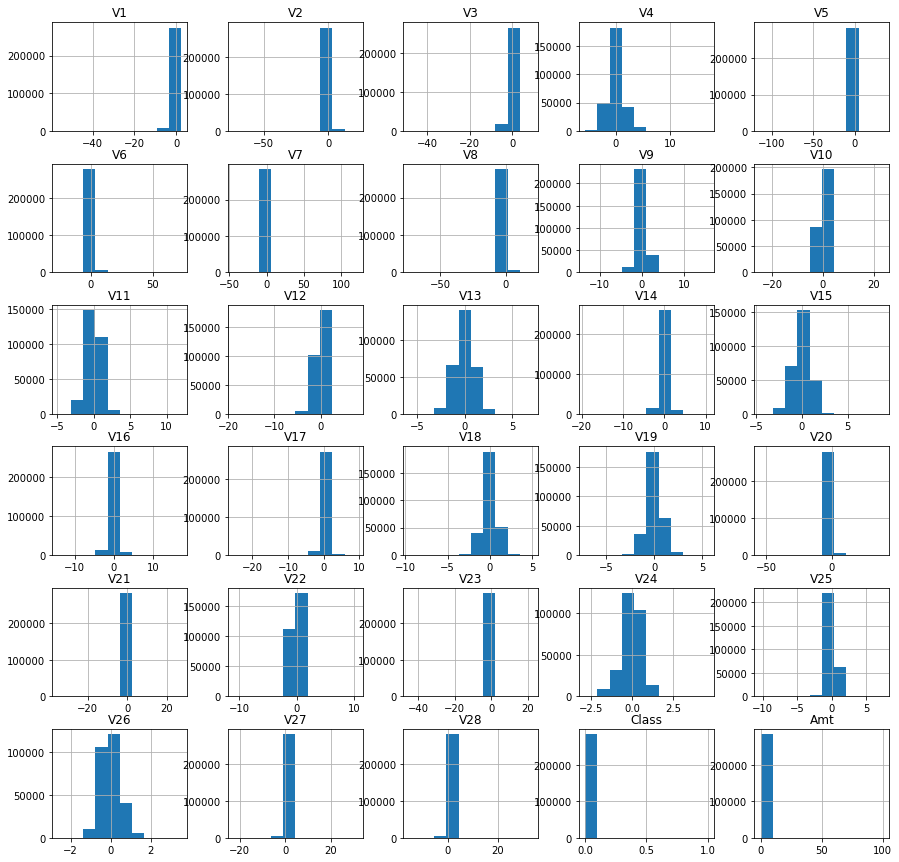

In [9]:
trans.hist(figsize = [15,15]);

In [10]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284807 entries, 0 to 96545
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     284

In [11]:
trans.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amt
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,2.848070e+05
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,0.001727,6.227075e-17
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.041527,1.000002e+00
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,-3.595522e-01
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000000,-3.291324e-01
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000000,-2.631645e-01
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.000000,-4.444575e-02
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000,1.003771e+02


<AxesSubplot:>

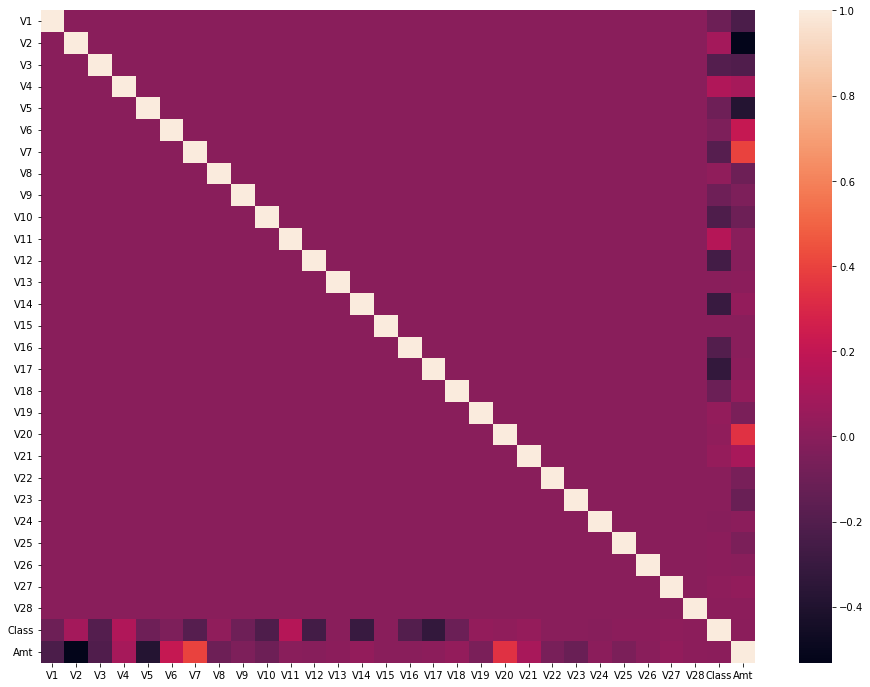

In [153]:
correl = trans.corr()

plt.subplots(figsize=(16,12))
sns.heatmap(correl)

Since the data has already been run through PCA transformation, there is little to be gleaned from this heatmap.

In [12]:
# Create feature and target files for each of the data files

transA_targ = trans_a['Class']
transA_feat = trans_a.drop(['Class'], axis=1)

transB_targ = trans_b['Class']
transB_feat = trans_b.drop(['Class'], axis=1)

In [13]:
from collections import Counter

print(sorted(Counter(transA_targ).items()))

[(0, 187893), (1, 368)]


In [14]:
print(sorted(Counter(transB_targ).items()))

[(0, 96422), (1, 124)]


transA has 187,893 non-fraudulent records, and 368 fraudulent records
transB has 96,422 non-fraudulent records, and 124 fraudulent records

For all the data, 284,807 total records, of which 492 represent fraudulent credit card charges.

In [15]:
# Create a function to batch report a number of metrics after models have been built

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

def print_results(true, pred):
    
    print("Accuracy:", accuracy_score(true, pred))
    print('ROCAUC score:',roc_auc_score(true, pred))
    print('F1 score:',f1_score(true, pred))
    print('Recall score:', recall_score(true, pred))
    print('Confusion Matrix: ','\n', confusion_matrix(true, pred))
    print('AUPRC:', average_precision_score(true, pred))
    
    unique, counts = np.unique(pred, return_counts=True)
    preds_dict = dict(zip(unique, counts))
    print('Predicted # Fraud cases: ', preds_dict[1])
    
    unique2, counts2 = np.unique(true, return_counts=True)
    true_dict = dict(zip(unique2, counts2))
    print('Actual # Fraud cases: ', true_dict[1])


I will start with some naive testing.  As mentioned, for now I will use the transA file as the training files and the transB files as the test files.

In [16]:
# Classifiers

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Graphing
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import RocCurveDisplay


In [17]:
# %%timeit -n 1 -r 1

# Decision Tree Classifier, base files, no special file handling.

clf = DecisionTreeClassifier(random_state=42)

clf = clf.fit(transA_feat, transA_targ)

preds = clf.predict(transB_feat)

print_results(transB_targ, preds)

Accuracy: 0.9988295734675698
ROCAUC score: 0.8343040605777962
F1 score: 0.5949820788530465
Recall score: 0.6693548387096774
Confusion Matrix:  
 [[96350    72]
 [   41    83]]
AUPRC: 0.3588533881171372
Predicted # Fraud cases:  155
Actual # Fraud cases:  124


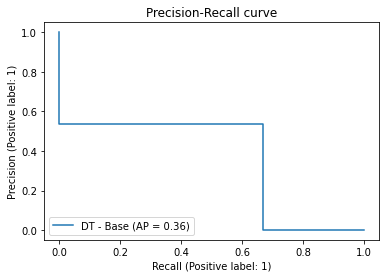

In [18]:
display = PrecisionRecallDisplay.from_estimator(clf, transB_feat, transB_targ, name="DT - Base")
_ = display.ax_.set_title("Precision-Recall curve")

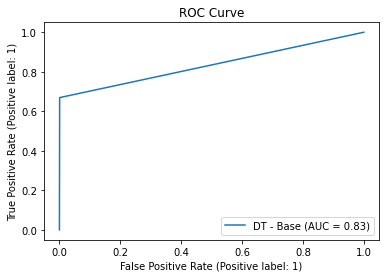

In [19]:
display = RocCurveDisplay.from_estimator(clf, transB_feat, transB_targ, name='DT - Base')
_ = display.ax_.set_title("ROC Curve")

In [20]:
#%%timeit -n 1 -r 1

# SVC - Base files

clf = SVC(gamma='auto')

clf = clf.fit(transA_feat, transA_targ)

preds = clf.predict(transB_feat)

print_results(transB_targ, preds)


Accuracy: 0.9993681768276262
ROCAUC score: 0.7580593305904623
F1 score: 0.6772486772486772
Recall score: 0.5161290322580645
Confusion Matrix:  
 [[96421     1]
 [   60    64]]
AUPRC: 0.50881005102339
Predicted # Fraud cases:  65
Actual # Fraud cases:  124


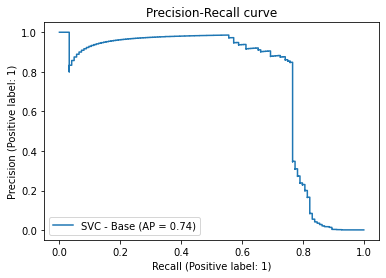

In [21]:
display = PrecisionRecallDisplay.from_estimator(clf, transB_feat, transB_targ, name="SVC - Base")
_ = display.ax_.set_title("Precision-Recall curve")

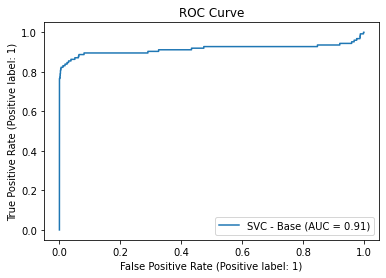

In [22]:
display = RocCurveDisplay.from_estimator(clf, transB_feat, transB_targ, name='SVC - Base')
_ = display.ax_.set_title("ROC Curve")

In [23]:
# Try Random Forest with the Base files
clf = RandomForestClassifier(criterion = 'entropy')

clf = clf.fit(transA_feat, transA_targ)

preds = clf.predict(transB_feat)

print_results(transB_targ, preds)

Accuracy: 0.9995339009384128
ROCAUC score: 0.8306296046746124
F1 score: 0.784688995215311
Recall score: 0.6612903225806451
Confusion Matrix:  
 [[96419     3]
 [   42    82]]
AUPRC: 0.6383856899274372
Predicted # Fraud cases:  85
Actual # Fraud cases:  124


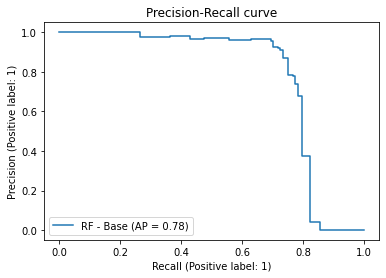

In [27]:
display = PrecisionRecallDisplay.from_estimator(clf, transB_feat, transB_targ, name="RF - Base")
_ = display.ax_.set_title("Precision-Recall curve")

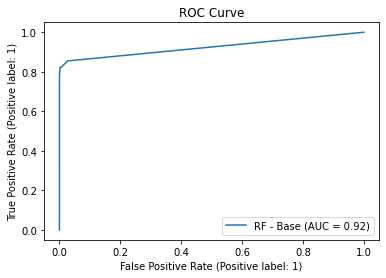

In [25]:
display = RocCurveDisplay.from_estimator(clf, transB_feat, transB_targ, name='RF - Base')
_ = display.ax_.set_title("ROC Curve")

As predicted, all of these naive models returned Accuracy Scores of greater than 99%.  But the Decision Tree classified 83 cases of fraud, out of 124 actual cases, falsely labeling 72 records as fraud.  The Support Vector Classifier got 64 of the 124, but only mis-classified 1 record.  The Random Forest Classifier got 83 out of 124, with 3 records labeled incorrectly.

These results can be improved.  We will go through the possibilities systematically.

In [28]:
# Let's undersample the majority class and match record counts

# Separate class
class_0 = trans_a[trans_a['Class'] == 0]
class_1 = trans_a[trans_a['Class'] == 1]

Total of Class 0 and 1 records: 0    368
1    368
Name: Class, dtype: int64


<AxesSubplot:title={'center':'count (target)'}>

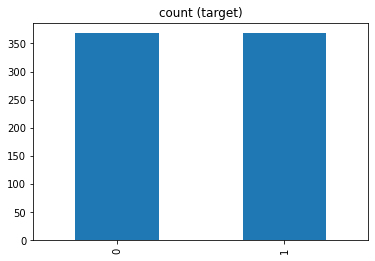

In [29]:
# Test an Under sampled file, with matching number of records for 0 and 1

count_1 = len(class_1)

class_0_small = class_0.sample(count_1)

test_under = pd.concat([class_0_small, class_1], axis=0)

print("Total of Class 0 and 1 records:", test_under['Class'].value_counts())
test_under['Class'].value_counts().plot(kind='bar', title='count (target)')


In [30]:
# Each class has 368 records

In [31]:
# Split the new small file
small_targ = test_under['Class']
small_feat = test_under.drop(['Class'], axis=1)

In [32]:
# Try a Decision Tree classifier on the small files

clf = DecisionTreeClassifier(random_state=42)

clf = clf.fit(small_feat, small_targ)

preds = clf.predict(transB_feat)

print_results(transB_targ, preds)

Accuracy: 0.9082406314088621
ROCAUC score: 0.8735198632891303
F1 score: 0.02294033307598985
Recall score: 0.8387096774193549
Confusion Matrix:  
 [[87583  8839]
 [   20   104]]
AUPRC: 0.0099606837588134
Predicted # Fraud cases:  8943
Actual # Fraud cases:  124


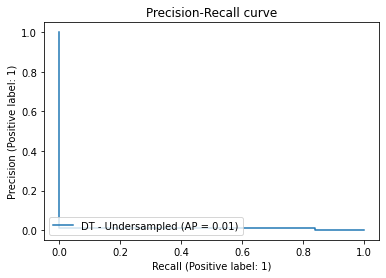

In [33]:
display = PrecisionRecallDisplay.from_estimator(clf, transB_feat, transB_targ, name="DT - Undersampled")
_ = display.ax_.set_title("Precision-Recall curve")

From SKLEARN Documentation:  "The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate."

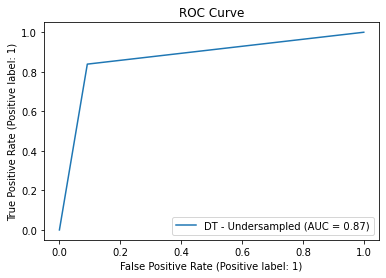

In [34]:
display = RocCurveDisplay.from_estimator(clf, transB_feat, transB_targ, name='DT - Undersampled')
_ = display.ax_.set_title("ROC Curve")

From SKLEARN documentation: “A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.”

In [35]:
# SVC - Undersampled file

clf = SVC(gamma='auto')

clf = clf.fit(small_feat, small_targ)

preds = clf.predict(transB_feat)

print_results(transB_targ, preds)

Accuracy: 0.9585482567895096
ROCAUC score: 0.9228684592794711
F1 score: 0.052108005684509705
Recall score: 0.8870967741935484
Confusion Matrix:  
 [[92434  3988]
 [   14   110]]
AUPRC: 0.023956781452304357
Predicted # Fraud cases:  4098
Actual # Fraud cases:  124


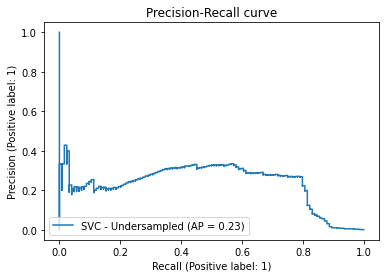

In [36]:
display = PrecisionRecallDisplay.from_estimator(clf, transB_feat, transB_targ, name="SVC - Undersampled")
_ = display.ax_.set_title("Precision-Recall curve")

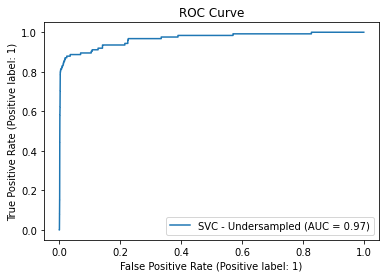

In [37]:
display = RocCurveDisplay.from_estimator(clf, transB_feat, transB_targ, name='SVC - Undersampled')
_ = display.ax_.set_title("ROC Curve")

In [38]:
# Try Random Forest with the UNDERSAMPLED files
clf = RandomForestClassifier(criterion = 'entropy')

clf = clf.fit(small_feat, small_targ)

preds = clf.predict(transB_feat)

print_results(transB_targ, preds)

Accuracy: 0.9905433679282415
ROCAUC score: 0.9187512252925815
F1 score: 0.18699910952804988
Recall score: 0.8467741935483871
Confusion Matrix:  
 [[95528   894]
 [   19   105]]
AUPRC: 0.08919708799475289
Predicted # Fraud cases:  999
Actual # Fraud cases:  124


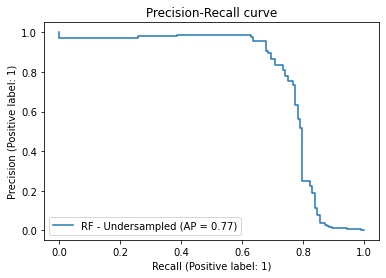

In [39]:
display = PrecisionRecallDisplay.from_estimator(clf, transB_feat, transB_targ, name="RF - Undersampled")
_ = display.ax_.set_title("Precision-Recall curve")

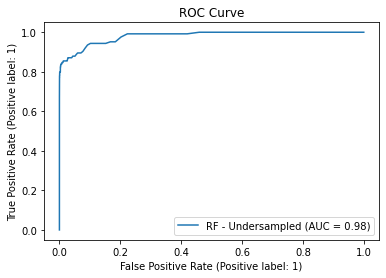

In [40]:
display = RocCurveDisplay.from_estimator(clf, transB_feat, transB_targ, name='RF - Undersampled')
_ = display.ax_.set_title("ROC Curve")

In all these cases, high numbers of false fraud predictions are returned.  Clearly, not enough information from the majority class is retained by the greatly diminished number of records.  Too much information was lost.  Moving on.

Again, I will take a naive approach and simply over sample the minority class to match the number of records in the majority class.

Total of Class 0 and 1 records: 1    187893
0    187893
Name: Class, dtype: int64


<AxesSubplot:title={'center':'count (target)'}>

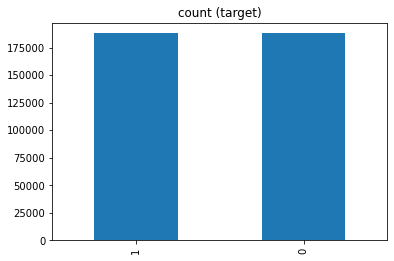

In [41]:
# This time, try to OVER sample!

count_1 = len(class_0)

class_1_big = class_1.sample(count_1, replace=True)

test_over = pd.concat([class_1_big, class_0], axis=0)

print("Total of Class 0 and 1 records:", test_over['Class'].value_counts())
test_over['Class'].value_counts().plot(kind='bar', title='count (target)')


In [42]:
# Split the new big file
big_targ = test_over['Class']
big_feat = test_over.drop(['Class'], axis=1)

In [43]:
# Now classify again, see if it does any better  DECISION TREE

# Try Decision Tree again
clf = DecisionTreeClassifier(random_state=42)

clf = clf.fit(big_feat, big_targ)

preds = clf.predict(transB_feat)

print_results(transB_targ, preds)

Accuracy: 0.9990160130922048
ROCAUC score: 0.8343974002720568
F1 score: 0.6360153256704981
Recall score: 0.6693548387096774
Confusion Matrix:  
 [[96368    54]
 [   41    83]]
AUPRC: 0.40594621265362213
Predicted # Fraud cases:  137
Actual # Fraud cases:  124


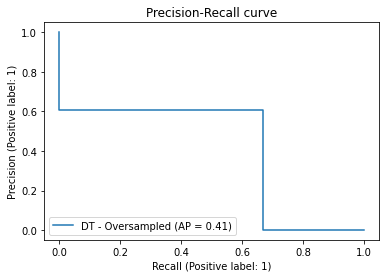

In [44]:
display = PrecisionRecallDisplay.from_estimator(clf, transB_feat, transB_targ, name="DT - Oversampled")
_ = display.ax_.set_title("Precision-Recall curve")

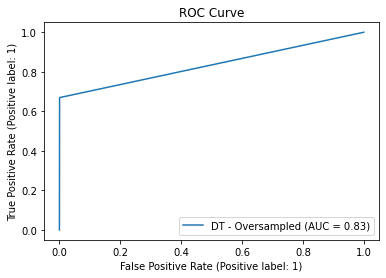

In [45]:
display = RocCurveDisplay.from_estimator(clf, transB_feat, transB_targ, name='DT - Oversampled')
_ = display.ax_.set_title("ROC Curve")

In [46]:
# Now SVC on the OVER sampled file
clf = SVC(gamma='auto')

clf = clf.fit(big_feat, big_targ)

preds = clf.predict(transB_feat)

print_results(transB_targ, preds)

Accuracy: 0.9989849398214322
ROCAUC score: 0.7578674656633708
F1 score: 0.5663716814159292
Recall score: 0.5161290322580645
Confusion Matrix:  
 [[96384    38]
 [   60    64]]
AUPRC: 0.32446713271462735
Predicted # Fraud cases:  102
Actual # Fraud cases:  124


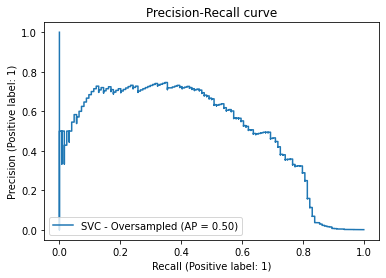

In [47]:
display = PrecisionRecallDisplay.from_estimator(clf, transB_feat, transB_targ, name="SVC - Oversampled")
_ = display.ax_.set_title("Precision-Recall curve")

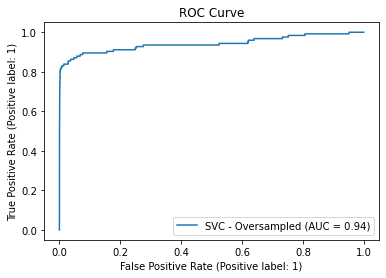

In [48]:
display = RocCurveDisplay.from_estimator(clf, transB_feat, transB_targ, name='SVC - Oversampled')
_ = display.ax_.set_title("ROC Curve")

In [49]:
# Try Random Forest with the OVERSAMPLED files
clf = RandomForestClassifier(criterion = 'entropy')

clf = clf.fit(big_feat, big_targ)

preds = clf.predict(transB_feat)

print_results(transB_targ, preds)

Accuracy: 0.9995649742091852
ROCAUC score: 0.8427263788681609
F1 score: 0.8018867924528302
Recall score: 0.6854838709677419
Confusion Matrix:  
 [[96419     3]
 [   39    85]]
AUPRC: 0.6625190551593384
Predicted # Fraud cases:  88
Actual # Fraud cases:  124


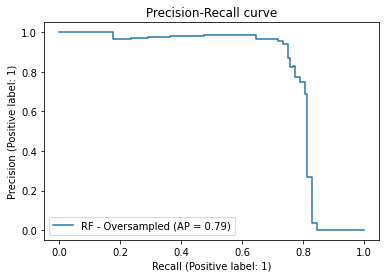

In [50]:
display = PrecisionRecallDisplay.from_estimator(clf, transB_feat, transB_targ, name="RF - Oversampled")
_ = display.ax_.set_title("Precision-Recall curve")

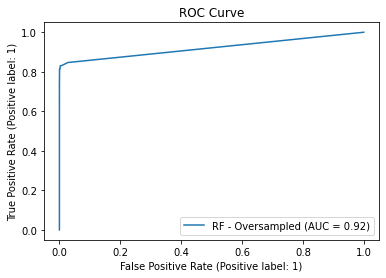

In [51]:
display = RocCurveDisplay.from_estimator(clf, transB_feat, transB_targ, name='RF - Oversampled')
_ = display.ax_.set_title("ROC Curve")

The Random Forest Classifier performed best on the OVER sampled file, correctly identifying 84 out of 124 records as fraudulent, while only mislabeling 3 records as fraudulent.  All three methods still had a high number of actual fraud cases labeled as non-fraudulent.

SMOTE - SMOTE stands for Synthetic Minority Oversampling Technique. While the simplistic oversampling approach used in the above code simply repeated existing instances of records from the minority class until the quantity matched the number of the majority class, SMOTE employs a statistical technique that creates new records that are not identical to the existing records.  SMOTE works by choosing a point from the minority class, and then finds a 'nearest neighbor'.  A point is then chosen between the existing point and the neighbor, creating a synthetic NEW data point.

SMOTE is available from IMBLEARN, a library of tools specifically designed to assist with imbalanced data.  From https://imbalanced-learn.org/stable/:  "Imbalanced-learn (imported as imblearn) is an open source, MIT-licensed library relying on scikit-learn (imported as sklearn) and provides tools when dealing with classification with imbalanced classes."

In [52]:
# SMOTE

from imblearn.over_sampling import SMOTE

In [53]:
SMOTE_oversample = SMOTE()

# SMOTE created values of the feature and target files
X_smote, y_smote = SMOTE_oversample.fit_resample(transA_feat, transA_targ)

In [54]:
# Run all three Classifiers again

In [55]:
# SMOTE  DECISION TREE

clf = DecisionTreeClassifier(random_state=42)

clf = clf.fit(X_smote, y_smote)

preds = clf.predict(transB_feat)

print_results(transB_targ, preds)

Accuracy: 0.9975037805812773
ROCAUC score: 0.8215590940629932
F1 score: 0.39900249376558605
Recall score: 0.6451612903225806
Confusion Matrix:  
 [[96225   197]
 [   44    80]]
AUPRC: 0.18678391179493906
Predicted # Fraud cases:  277
Actual # Fraud cases:  124


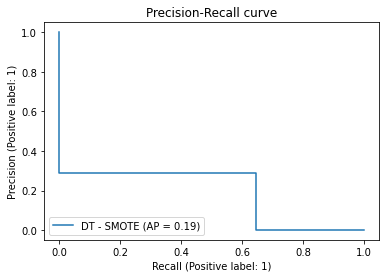

In [56]:
display = PrecisionRecallDisplay.from_estimator(clf, transB_feat, transB_targ, name="DT - SMOTE")
_ = display.ax_.set_title("Precision-Recall curve")

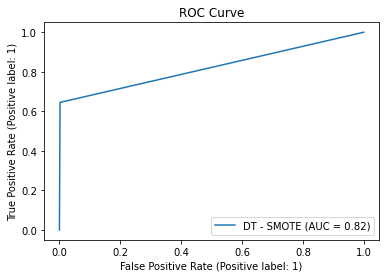

In [57]:
display = RocCurveDisplay.from_estimator(clf, transB_feat, transB_targ, name='DT - SMOTE')
_ = display.ax_.set_title("ROC Curve")

In [58]:
# SMOTE  SVC

clf = SVC(gamma='auto')

clf = clf.fit(X_smote, y_smote)

preds = clf.predict(transB_feat)

print_results(transB_targ, preds)

Accuracy: 0.9990056553352806
ROCAUC score: 0.761904909266457
F1 score: 0.575221238938053
Recall score: 0.5241935483870968
Confusion Matrix:  
 [[96385    37]
 [   59    65]]
AUPRC: 0.3346560159444204
Predicted # Fraud cases:  102
Actual # Fraud cases:  124


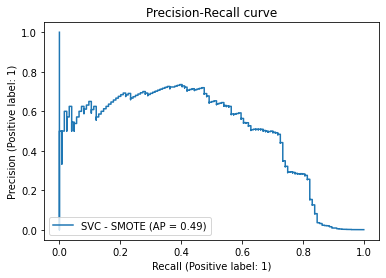

In [59]:
display = PrecisionRecallDisplay.from_estimator(clf, transB_feat, transB_targ, name="SVC - SMOTE")
_ = display.ax_.set_title("Precision-Recall curve")

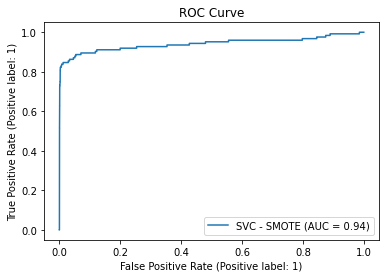

In [60]:
display = RocCurveDisplay.from_estimator(clf, transB_feat, transB_targ, name='SVC - SMOTE')
_ = display.ax_.set_title("ROC Curve")

In [61]:
# SMOTE  with Random Forest

clf = RandomForestClassifier(criterion = 'entropy')

clf = clf.fit(X_smote, y_smote)

preds = clf.predict(transB_feat)

print_results(transB_targ, preds)

Accuracy: 0.9995960474799578
ROCAUC score: 0.8628772981136015
F1 score: 0.8219178082191779
Recall score: 0.7258064516129032
Confusion Matrix:  
 [[96417     5]
 [   34    90]]
AUPRC: 0.6879582757897508
Predicted # Fraud cases:  95
Actual # Fraud cases:  124


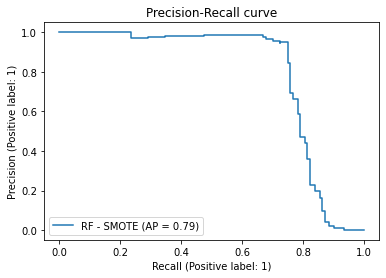

In [62]:
display = PrecisionRecallDisplay.from_estimator(clf, transB_feat, transB_targ, name="RF - SMOTE")
_ = display.ax_.set_title("Precision-Recall curve")

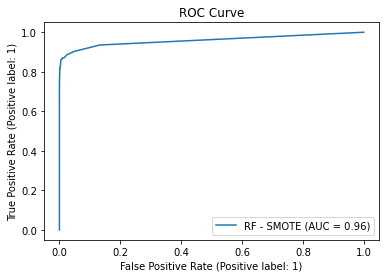

In [63]:
display = RocCurveDisplay.from_estimator(clf, transB_feat, transB_targ, name='RF - SMOTE')
_ = display.ax_.set_title("ROC Curve")

SMOTE oversampling, classified by a Random Forest Classifier performed best thus far, with 93 correctly identified cases of fraud, 6 predicted cases of fraud that were legitimate, and 31 cases predicted to be OK that were actually fraud.  

SMOTE with Tomek Links - Combines SMOTE oversampling of the minority class with Tomek Links, which removes members of the majority class that are close to members of the majority class, making it a form of undersampling.  After SMOTE is complete, as described above, members of the majority class are sampled.  If the nearest neighbor to that majority class point is a member of the minority class, the point is removed.

In [68]:
# Import the SMOTE tomek library
from imblearn.combine import SMOTETomek

In [83]:
# Resample the data yet again, using SMOTE-Tomek set for the minority class.  

smt = SMOTETomek(sampling_strategy = 'minority', random_state=42)

# Create new files for classification testing

X_smt, y_smt = smt.fit_resample(transA_feat, transA_targ)

In [84]:
# Run all three classifiers again

In [85]:
# SMOTE-Tomek  DECISION TREE

clf = DecisionTreeClassifier(random_state=42)

clf = clf.fit(X_smt, y_smt)

preds = clf.predict(transB_feat)

print_results(transB_targ, preds)

Accuracy: 0.997224121144325
ROCAUC score: 0.8254461570475484
F1 score: 0.3767441860465116
Recall score: 0.6532258064516129
Confusion Matrix:  
 [[96197   225]
 [   43    81]]
AUPRC: 0.17335809702022467
Predicted # Fraud cases:  306
Actual # Fraud cases:  124


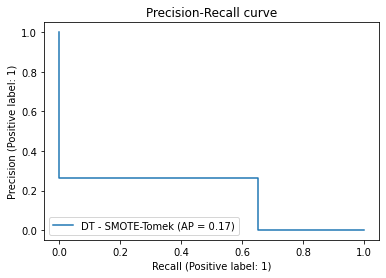

In [86]:
display = PrecisionRecallDisplay.from_estimator(clf, transB_feat, transB_targ, name="DT - SMOTE-Tomek")
_ = display.ax_.set_title("Precision-Recall curve")

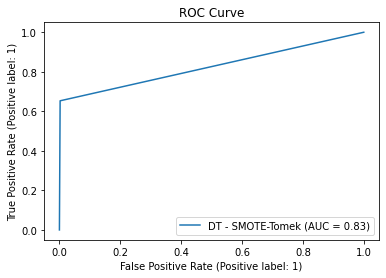

In [87]:
display = RocCurveDisplay.from_estimator(clf, transB_feat, transB_targ, name='DT - SMOTE-Tomek')
_ = display.ax_.set_title("ROC Curve")

In [88]:
# SMOTE-Tomek  SVC

clf = SVC(gamma='auto')

clf = clf.fit(X_smt, y_smt)

preds = clf.predict(transB_feat)

print_results(transB_targ, preds)

Accuracy: 0.9989849398214322
ROCAUC score: 0.761894538189317
F1 score: 0.5701754385964912
Recall score: 0.5241935483870968
Confusion Matrix:  
 [[96383    39]
 [   59    65]]
AUPRC: 0.32823207540046095
Predicted # Fraud cases:  104
Actual # Fraud cases:  124


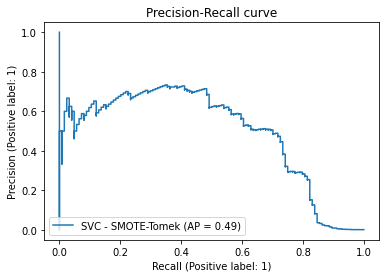

In [89]:
display = PrecisionRecallDisplay.from_estimator(clf, transB_feat, transB_targ, name="SVC - SMOTE-Tomek")
_ = display.ax_.set_title("Precision-Recall curve")

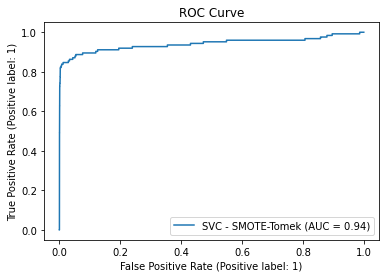

In [90]:
display = RocCurveDisplay.from_estimator(clf, transB_feat, transB_targ, name='SVC - SMOTE-Tomek')
_ = display.ax_.set_title("ROC Curve")

In [91]:
# SMOTE-Tomek  Random Forest

clf = RandomForestClassifier(criterion = 'entropy')

clf = clf.fit(X_smt, y_smt)

preds = clf.predict(transB_feat)

print_results(transB_targ, preds)

Accuracy: 0.9996374785076544
ROCAUC score: 0.8749792578457198
F1 score: 0.841628959276018
Recall score: 0.75
Confusion Matrix:  
 [[96418     4]
 [   31    93]]
AUPRC: 0.7193932554131026
Predicted # Fraud cases:  97
Actual # Fraud cases:  124


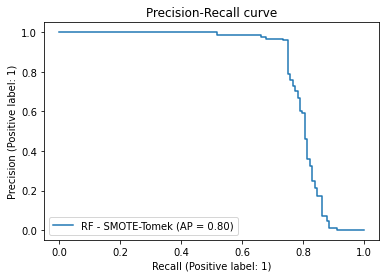

In [92]:
display = PrecisionRecallDisplay.from_estimator(clf, transB_feat, transB_targ, name="RF - SMOTE-Tomek")
_ = display.ax_.set_title("Precision-Recall curve")

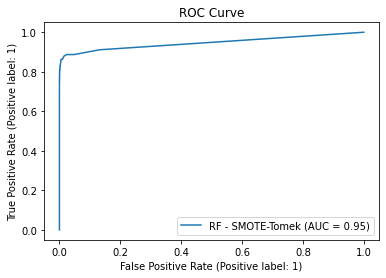

In [93]:
display = RocCurveDisplay.from_estimator(clf, transB_feat, transB_targ, name='RF - SMOTE-Tomek')
_ = display.ax_.set_title("ROC Curve")

In [ ]:
# About 90 minutes to complete the above.

Consistently, the Random Forest Classifier has outperformed the Decision Tree and Support Vector Classifiers.  We can attempt to hypertune parameters for Random Forest.

In [94]:
rf = RandomForestClassifier(criterion = 'entropy')

In [95]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [96]:
from sklearn.model_selection import GridSearchCV

In [97]:
# Define Parameters
max_depth=[2, 8, 16]  # none is the default
n_estimators = [64, 128, 256]  # 100 is the default
criterion = ['entropy', 'gini']  # entropy is default

param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, criterion=criterion)

# Build the grid search
dfrst = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 5)
grid_results = grid.fit(X_smt, y_smt)

# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
results_df = pd.DataFrame(grid_results.cv_results_)
results_df

Best: [0.93232585 0.9323019  0.93229391 0.97869    0.9787033  0.97881507
 0.99970196 0.99969131 0.99972325 0.93231787 0.93234448 0.93269308
 0.97952292 0.97963203 0.97945639 0.99967003 0.99970196 0.99970196], using {'criterion': 'entropy', 'max_depth': 16, 'n_estimators': 256}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.282642,0.556745,0.066401,0.004373,entropy,2,64,"{'criterion': 'entropy', 'max_depth': 2, 'n_es...",0.931438,0.932688,0.933220,0.932967,0.931317,0.932326,0.000793,15
1,11.709797,0.858306,0.102142,0.004666,entropy,2,128,"{'criterion': 'entropy', 'max_depth': 2, 'n_es...",0.931318,0.932621,0.933606,0.932874,0.931091,0.932302,0.000955,17
2,20.308843,0.746550,0.167031,0.002437,entropy,2,256,"{'criterion': 'entropy', 'max_depth': 2, 'n_es...",0.931411,0.932661,0.933326,0.932874,0.931197,0.932294,0.000839,18
3,16.282504,0.355513,0.084316,0.001583,entropy,8,64,"{'criterion': 'entropy', 'max_depth': 8, 'n_es...",0.979976,0.978392,0.977274,0.977860,0.979949,0.978690,0.001097,12
4,31.630819,0.336026,0.133289,0.001131,entropy,8,128,"{'criterion': 'entropy', 'max_depth': 8, 'n_es...",0.979523,0.976423,0.979031,0.977940,0.980601,0.978703,0.001426,11
5,62.272700,0.667194,0.239196,0.004647,entropy,8,256,"{'criterion': 'entropy', 'max_depth': 8, 'n_es...",0.979989,0.977740,0.977434,0.978685,0.980228,0.978815,0.001136,10
6,19.030412,0.503756,0.090985,0.003644,entropy,16,64,"{'criterion': 'entropy', 'max_depth': 16, 'n_e...",0.999348,0.999641,0.999960,0.999814,0.999747,0.999702,0.000205,2
7,38.049537,0.739430,0.148333,0.001704,entropy,16,128,"{'criterion': 'entropy', 'max_depth': 16, 'n_e...",0.999335,0.999667,0.999920,0.999814,0.999721,0.999691,0.000198,5
8,75.516470,1.539013,0.274576,0.012924,entropy,16,256,"{'criterion': 'entropy', 'max_depth': 16, 'n_e...",0.999415,0.999681,0.999894,0.999854,0.999774,0.999723,0.000171,1
9,4.187655,0.052362,0.063438,0.002153,gini,2,64,"{'criterion': 'gini', 'max_depth': 2, 'n_estim...",0.930679,0.933020,0.933646,0.933140,0.931104,0.932318,0.001191,16


In [ ]:
# starting at 4:50pm  --  finished at 6:05

In [98]:
# See if that helps!

clf = RandomForestClassifier(criterion = 'entropy', max_depth = 16, n_estimators = 256)

clf = clf.fit(X_smt, y_smt)

preds = clf.predict(transB_feat)

print_results(transB_targ, preds)

Accuracy: 0.9995960474799578
ROCAUC score: 0.8709314431654936
F1 score: 0.8251121076233184
Recall score: 0.7419354838709677
Confusion Matrix:  
 [[96415     7]
 [   32    92]]
AUPRC: 0.6898068473743917
Predicted # Fraud cases:  99
Actual # Fraud cases:  124


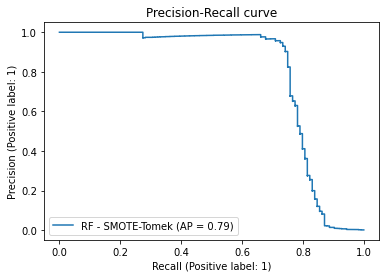

In [99]:
display = PrecisionRecallDisplay.from_estimator(clf, transB_feat, transB_targ, name="RF - SMOTE-Tomek")
_ = display.ax_.set_title("Precision-Recall curve")

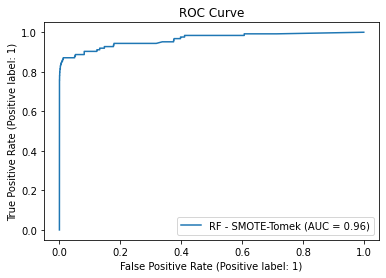

In [100]:
display = RocCurveDisplay.from_estimator(clf, transB_feat, transB_targ, name='RF - SMOTE-Tomek')
_ = display.ax_.set_title("ROC Curve")

The tuning DID NOT exactly help.  However, the max_depth param defaults to 'None', which will run until finishing regardless of the depth.  I am going to change that back to 'None', but leave the n_estimators at 256 - the default is 100.  If I have time, I will rerun the above with THOSE params.

In [101]:
# double check the whole file is as we expect

trans

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amt
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244887
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.348685
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.170169
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.139366
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.076805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96541,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.338357
96542,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,-0.244190
96543,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,-0.075262
96544,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,-0.302172


From the SKLEARN Documentation regarding the Precision Recall Curve:  "Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall)."

In this section, I spent some time on OVERFIT models.  Since that code took a long time to run, I deleted out those cells.  Below I will do it properly.

Now run SMOTE-Tomek on a more traditional Train-Test split using the whole data set, then build a Random Forest model using tuned params.  Maybe with a few more train instances, after the SMOTE-Tomek over/under sampling, it might perform even better still. 

In [64]:
# Triple check the original file

trans

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amt
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244887
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.348685
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.170169
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.139366
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.076805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96541,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.338357
96542,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,-0.244190
96543,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,-0.075262
96544,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,-0.302172


In [65]:
# Split into features and target

trans_targ = trans['Class']
trans_feat = trans.drop(['Class'], axis=1)

In [66]:
# Split into 70%/30% Train and Test sets.

X_train, X_test, y_train, y_test = train_test_split(trans_feat, trans_targ, test_size=0.3, random_state=42)

In [69]:
# Run the SMOTE-Tomek resampler on JUST the split out training sets

smt = SMOTETomek(sampling_strategy = 'minority', random_state=1234)

X_ST2, y_ST2 = smt.fit_resample(X_train, y_train)

In [70]:
# NOW create the model using those files, then check against the X_test and y_test

# Build a Random Forest Model with the tuned Params on the SMOTE-Tomek sampled files

clf = RandomForestClassifier(criterion='entropy', n_estimators = 256)

clf = clf.fit(X_ST2, y_ST2)

preds = clf.predict(X_test)

print_results(y_test, preds)

Accuracy: 0.9995318516437859
ROCAUC score: 0.9300239739653114
F1 score: 0.854014598540146
Recall score: 0.8602941176470589
Confusion Matrix:  
 [[85286    21]
 [   19   117]]
AUPRC: 0.7296021658656212
Predicted # Fraud cases:  138
Actual # Fraud cases:  136


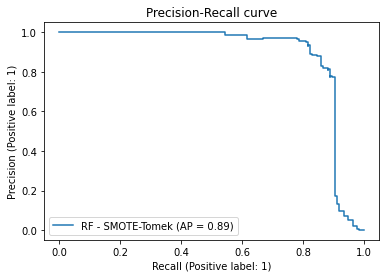

In [71]:
display = PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, name="RF - SMOTE-Tomek")
_ = display.ax_.set_title("Precision-Recall curve")

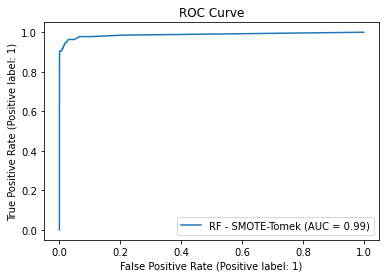

In [72]:
display = RocCurveDisplay.from_estimator(clf, X_test, y_test, name='RF - SMOTE-Tomek')
_ = display.ax_.set_title("ROC Curve")

The below cells were initial attempts to do more with Outlier Detection.  I did not end up with enough time to pursue them further.



In [ ]:
# Outlier Detection?

In [125]:
from sklearn.decomposition import KernelPCA
from sklearn.svm import OneClassSVM

In [ ]:
# # KPCA 

# # Fitting KPCA with only training data:

# kpca = KernelPCA(n_components = 20, n_jobs = -1, kernel = 'rbf')
# kpcamodel = kpca.fit(X_train)
# X_train_kpca = kpcamodel.transform(X_train)
# X_test_kpca = kpcamodel.transform(X_test)

# # Training model with "majority" class, leaving Class = 1 out:
# train_final = pd.concat([pd.DataFrame(X_train_kpca), y_train], axis =1)
# train_0 = train_final[train_final['Convert']==0]
# train_1 = train_final[train_final['Convert']==1]

# # Prediction: 

# model = OneClassSVM() #again for controlled comparison, no hyperparameters will be tuned
# result = model.fit(train_0)
# y_pred = result.predict(X_test_kpca)
# confusion_matrix(y_train, y_pred)

In [ ]:
# The above code blew up Notebook.

In [74]:
# Isolation Forest

from sklearn.ensemble import IsolationForest

In [130]:
# use the train and test files from above

clf = IsolationForest(n_estimators = 500, max_features = 5)

clf = clf.fit(X_train, y_train)

preds = clf.predict(X_test)

# print_results(y_test, preds)

/Users/pauloleary/opt/miniconda3/envs/CAP_env/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [131]:
preds

array([-1,  1,  1, ...,  1,  1,  1])

OK.  -1 would be the '1' in the actual file, and 1 would be 0.

In [132]:
type(preds)

numpy.ndarray

In [133]:
print(sorted(Counter(preds).items()))

[(-1, 3430), (1, 82013)]


In [134]:
# Change the 1s to 0, and the -1s to 1  ???
preds2 = np.where(preds==1, 0, preds)
# np.where(preds==-1, 1, preds)

In [135]:
preds2

array([-1,  0,  0, ...,  0,  0,  0])

In [136]:
preds3 = np.where(preds2==-1, 1, preds2)

In [137]:
preds3

array([1, 0, 0, ..., 0, 0, 0])

In [138]:
print_results(y_test, preds3)

Accuracy: 0.9609330196739346
ROCAUC score: 0.8996819618278343
F1 score: 0.0639371845204711
Recall score: 0.8382352941176471
Confusion Matrix:  
 [[81991  3316]
 [   22   114]]
AUPRC: 0.028117196910615053
Predicted # Fraud cases:  3430
Actual # Fraud cases:  136


In [139]:
# Repeat the above with unsupervised approach

trans

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amt
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244887
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.348685
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.170169
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.139366
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.076805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96541,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.338357
96542,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,-0.244190
96543,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,-0.075262
96544,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,-0.302172


In [140]:
trans_X = trans[:200000]

In [141]:
trans_y = trans[200001:]

In [146]:
clf = IsolationForest(n_estimators = 500, max_features = 5)

clf = clf.fit(trans_X)

preds = clf.predict(trans_y)


/Users/pauloleary/opt/miniconda3/envs/CAP_env/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [147]:
preds

array([1, 1, 1, ..., 1, 1, 1])

In [148]:
print(sorted(Counter(preds).items()))

[(-1, 3557), (1, 81249)]


In [ ]:
# Still way too many -1s

In [ ]:
display = PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, name="RF - SMOTE-Tomek")
_ = display.ax_.set_title("Precision-Recall curve")